Rock - Paper - Scissors CNN Classifier

In [154]:

import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [155]:
seed = 17
image_size = (150, 150)
batch_size = 710
classes = ("paper", "rock", "scissors")
validation_split = 0.2

Preprocessing
Explore the dataset thoroughly and provide a summary of your observations.
Perform necessary preprocessing steps:
    - [x] Explore and plot the data
    - [x] Image resizing.
    - [x] Image normalization.
    - [x] Optionally, data augmentation techniques.
    - [x] Splitting the data into training and test sets appropriately.

In [156]:
initial_train_ds = tf.keras.utils.image_dataset_from_directory(
    "data_reconstructed/train",
    image_size=image_size,
    shuffle=True,
    seed=seed,
    
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "data_reconstructed/validation",
    image_size=image_size,
    shuffle=False,
    seed=seed,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "data_reconstructed/test",
    image_size=image_size,
    shuffle=False,
    seed=seed,
)

Found 1531 files belonging to 3 classes.
Found 437 files belonging to 3 classes.
Found 220 files belonging to 3 classes.


In [157]:
def visualize_dataset(train_ds, classes):
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(12):
            plt.subplot(4, 3, i + 1)
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(classes[int(labels[i])])
            plt.axis("off")

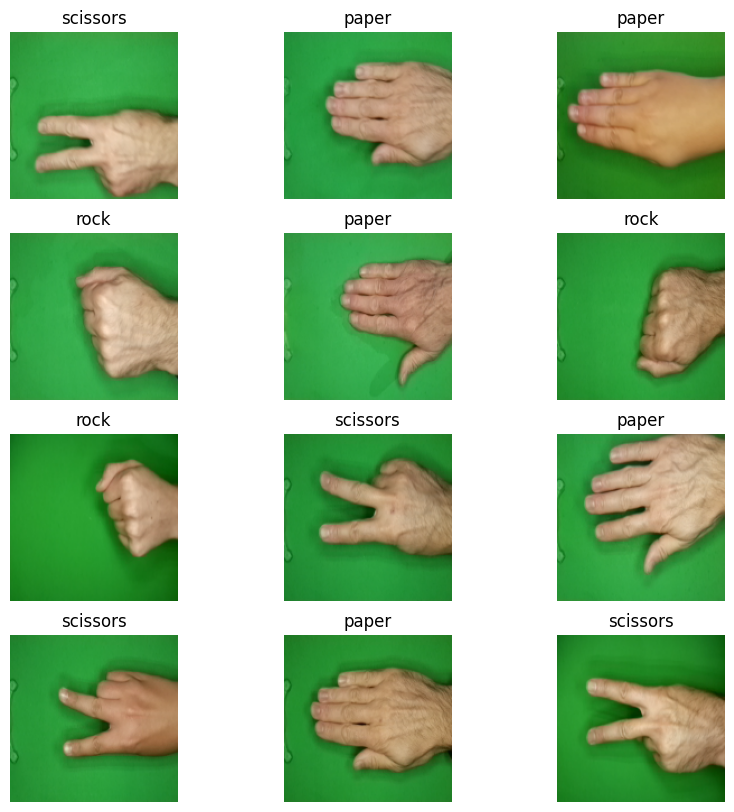

In [143]:
visualize_dataset(initial_train_ds, classes)

In [158]:
# data augmentation
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", seed=seed),
    layers.RandomBrightness(0.2, seed=seed),
    layers.RandomZoom(0.2, seed=seed),
    layers.RandomContrast(0.4, seed=seed),
    layers.RandomCrop(height=image_size[0], width=image_size[1], seed=seed),
])

augmented_train_ds = initial_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


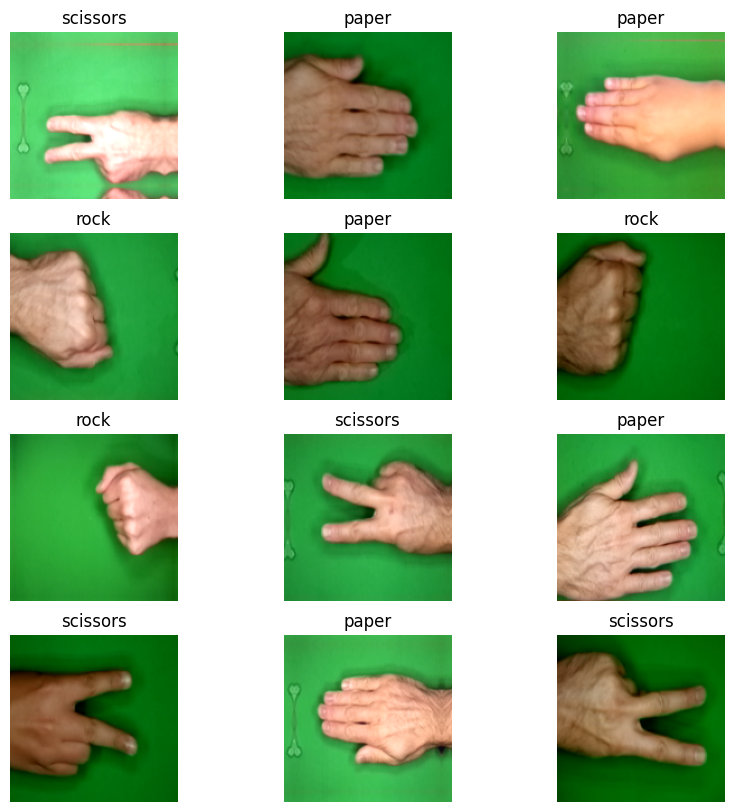

In [159]:
visualize_dataset(augmented_train_ds, classes)

### Image normalization.

In [160]:
# normalization
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = augmented_train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

In [161]:
# convert datasets to numpy arrays for further processing
def dataset_to_numpy(ds):
    X, y = [], []
    for images, labels in ds:
        X.append(images.numpy())
        y.append(labels.numpy())
    return tf.concat(X, axis=0), tf.concat(y, axis=0)

In [162]:
X_train, y_train = dataset_to_numpy(train_ds)
X_validation, y_validation = dataset_to_numpy(val_ds)
X_test, y_test = dataset_to_numpy(test_ds)

In [113]:
# are the datasets balanced?
print(np.unique(y_train,return_counts=True),np.unique(y_validation,return_counts=True), np.unique(y_test,return_counts=True))

(array([0, 1, 2], dtype=int32), array([498, 508, 525])) (array([0, 1, 2], dtype=int32), array([142, 145, 150])) (array([0, 1, 2], dtype=int32), array([72, 73, 75]))


In [147]:
from sklearn.utils.class_weight import compute_class_weight

y_train_np = y_train.numpy() if hasattr(y_train, 'numpy') else np.array(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: np.float64(1.0247657295850068), 1: np.float64(1.0045931758530184), 2: np.float64(0.9720634920634921)}


The dataset is not imbalanced since the differences between the occurance of classes is not big.

Simple model
- one convolutional layer, 32 fiters 3x3 grid
- maxpooling 2x2
- hidden layer NN with 512 neurons
- softmax

In [148]:
def build_simple_model(hp):
    model = Sequential()
    model.add(Input(shape=(image_size[0], image_size[1], 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(
        filters=hp.Int('conv_filters', min_value=32, max_value=128, step=32),
        kernel_size=3,
        activation='relu',
    ))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense( 
        units = hp.Int('dense_units', min_value=128, max_value=512, step=128), 
        activation='relu'))
    model.add(Dense(units=3, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4], default=1e-3)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Tuning the model
Tuning params
 - Number of filters for the Convolutional Layer
 - Number of units for the densely-connected NN layer
 - Learning rate for the Optimizer

In [149]:
import keras_tuner as kt

tuner = kt.Hyperband(
    build_simple_model,
    objective='val_accuracy',
    max_epochs=30,
    directory='tuning',
    project_name='cnn_tuning'
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


Reloading Tuner from tuning/cnn_tuning/tuner0.json


In [ ]:

tuner.search(train_ds, validation_data=val_ds, epochs=30, callbacks=[stop_early])

Trial 21 Complete [00h 01m 01s]
val_accuracy: 0.8764302134513855

Best val_accuracy So Far: 0.8901602029800415
Total elapsed time: 01h 24m 40s

Search: Running Trial #22

Value             |Best Value So Far |Hyperparameter
64                |64                |conv_filters
128               |512               |dense_units
0.01              |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
48/48 ━━━━━━━━━━━━━━━━━━━━ 46s 957ms/step - accuracy: 0.3506 - loss: 66.7114 - val_accuracy: 0.3524 - val_loss: 1.0941
Epoch 2/2
18/48 ━━━━━━━━━━━━━━━━━━━━ 27s 919ms/step - accuracy: 0.3387 - loss: 1.0989

KeyboardInterrupt: 

In [150]:
best_model_1 = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
best_learning_rate = best_hyperparams.get('learning_rate')
best_conv_filters = best_hyperparams.get('conv_filters')
best_dense_units = best_hyperparams.get('dense_units')
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_epoch = best_trial.hyperparameters.get('tuner/epochs')

print("Best Conv filters:", best_hyperparams.get('conv_filters'))
print("Best Dense units:", best_hyperparams.get('dense_units'))
print("Best Learning rate:", best_hyperparams.get('learning_rate'))
print("Best Epoch:", best_epoch)

best_model_1.summary()

Best Conv filters: 64
Best Dense units: 512
Best Learning rate: 0.001
Best Epoch: 2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 341056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   174,621,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,642,115 (666.21 MB)

 Trainable params: 174,642,115 (666.21 MB)

 Non-trainable params: 0 (0.00 B)

### Used tuned params 

In [14]:
best_model_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
best_model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 341056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   174,621,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,642,115 (666.21 MB)

 Trainable params: 174,642,115 (666.21 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Find best batch size
import numpy as np
batch_sizes = [16, 32, 64]  

# Initialize a list to store results
results = []

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    
    # Create the model for the current batch size
    model = best_model_1
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_validation, y_validation), callbacks=[stop_early])

    # Record the validation accuracy or loss (depending on your goal)
    val_accuracy = history.history['val_accuracy'][-1]  # Last epoch validation accuracy
    results.append((batch_size, val_accuracy))
    print(f"Validation Accuracy for batch size {batch_size}: {val_accuracy}")

# Sort the results to find the best batch size
results = sorted(results, key=lambda x: x[1], reverse=True)

# Output the best batch size and its validation accuracy
best_batch_size, best_val_accuracy = results[0]
print(f"Best Batch Size: {best_batch_size}, Best Validation Accuracy: {best_val_accuracy}")


Training with batch size: 16
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 572ms/step - accuracy: 0.8762 - loss: 0.3517 - val_accuracy: 0.9176 - val_loss: 0.2521
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 562ms/step - accuracy: 0.9314 - loss: 0.1768 - val_accuracy: 0.9336 - val_loss: 0.2263
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 65s 683ms/step - accuracy: 0.9784 - loss: 0.0727 - val_accuracy: 0.9016 - val_loss: 0.3400
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 795ms/step - accuracy: 0.9855 - loss: 0.0471 - val_accuracy: 0.9245 - val_loss: 0.2538
Validation Accuracy for batch size 16: 0.9244851469993591
Training with batch size: 32
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9987 - loss: 0.0206 - val_accuracy: 0.9451 - val_loss: 0.1862
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9953 - loss: 0.0116 - val_accuracy: 0.9565 - val_loss: 0.1687
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9565 - val_los

In [22]:

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

simple_history = best_model_1.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    epochs=5,
    callbacks=[early_stopping, checkpointer],
    batch_size=32
).history


Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 1.0000 - loss: 3.2662e-04

48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 848ms/step - accuracy: 1.0000 - loss: 3.2638e-04 - val_accuracy: 0.9565 - val_loss: 0.1904
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 842ms/step - accuracy: 1.0000 - loss: 2.6029e-04 - val_accuracy: 0.9565 - val_loss: 0.1957
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 870ms/step - accuracy: 1.0000 - loss: 2.8175e-04 - val_accuracy: 0.9519 - val_loss: 0.1930
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 1.0000 - loss: 1.8140e-04 - val_accuracy: 0.9497 - val_loss: 0.1961


In [ ]:
best_model_1.save("rock_paper_scissors_simple_cnn_resized.keras")
with open("simple_history_resized.json", "w") as f:
    json.dump(simple_history, f)

In [168]:
# load fitted model
import keras
best_model_1 = keras.models.load_model("rock_paper_scissors_simple_cnn_resized.keras")

# load history
simple_history = json.load(open("simple_history_resized.json"))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Simple Model Results

In [121]:
def predict(model, X_test):
    y_pred = model.predict(X_test)
    pred = np.argmax(y_pred, axis=1)
    return pred

### Provide visualizations of training curves (loss and accuracy)

In [48]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [92]:
initialModel = Sequential()
initialModel.add(Input(shape=(image_size[0], image_size[1], 3)))
initialModel.add(Conv2D(best_conv_filters, (3,3), activation='relu'))
initialModel.add(MaxPooling2D(2,2))
initialModel.add(Flatten())
initialModel.add(Dense(best_dense_units, activation='relu'))
initialModel.add(Dense(3, activation='softmax'))

initialModel.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
initialModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 198, 298, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 99, 149, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 944064)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │   483,361,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 483,364,611 (1.80 GB)

 Trainable params: 483,364,611 (1.80 GB)

 Non-trainable params: 0 (0.00 B)

In [94]:
import json
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
)
# fit initial model
initial_history = initialModel.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping],
).history

# save the initial model
initialModel.save("best_model_initial.keras")
# load the initial model
initialModel = keras.models.load_model("best_model_initial.keras")

# save history
with open("initial_history.json", "w") as f:
    json.dump(initial_history, f)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 212s 9s/step - accuracy: 0.3612 - loss: 68.3220 - val_accuracy: 0.4005 - val_loss: 1.7669
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 194s 8s/step - accuracy: 0.6409 - loss: 1.1662 - val_accuracy: 0.6178 - val_loss: 0.9544
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 192s 8s/step - accuracy: 0.8549 - loss: 0.4083 - val_accuracy: 0.8398 - val_loss: 0.4862
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 199s 8s/step - accuracy: 0.9296 - loss: 0.2208 - val_accuracy: 0.8741 - val_loss: 0.4009
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 200s 8s/step - accuracy: 0.9698 - loss: 0.1271 - val_accuracy: 0.8261 - val_loss: 0.4889
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 191s 8s/step - accuracy: 0.9916 - loss: 0.0617 - val_accuracy: 0.7551 - val_loss: 0.6362


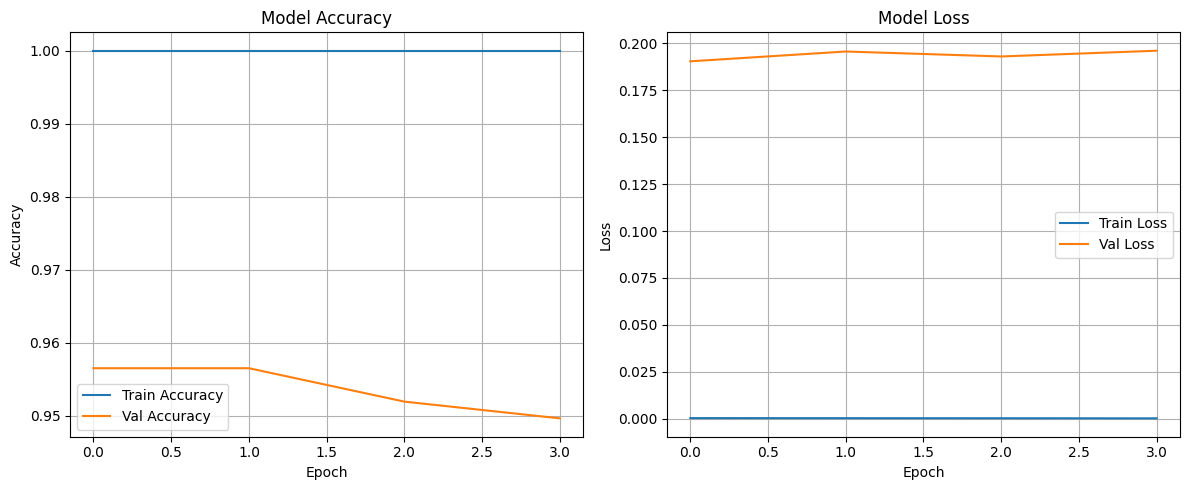

In [152]:
# Plot training & validation accuracy values
plot_history(simple_history)

In [179]:
model_1_improvement = Sequential()
model_1_improvement.add(Input(shape=(image_size[0], image_size[1], 3)))
model_1_improvement.add(Conv2D(32, (3,3), activation='relu'))
model_1_improvement.add(MaxPooling2D(2,2))
model_1_improvement.add(Dropout(0.4))
model_1_improvement.add(Flatten())
model_1_improvement.add(Dense(512, activation='relu'))
model_1_improvement.add(Dropout(0.6))
model_1_improvement.add(Dense(3, activation='softmax'))

model_1_improvement.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_1_improvement.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    89,719,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,721,731 (342.26 MB)

 Trainable params: 89,721,731 (342.26 MB)

 Non-trainable params: 0 (0.00 B)

In [180]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model_1_improvement.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    epochs=20,
    callbacks=[early_stopping],
    batch_size=32, 
    class_weight=class_weights_dict
)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 597ms/step - accuracy: 0.3704 - loss: 10.1042 - val_accuracy: 0.4828 - val_loss: 1.0014
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 586ms/step - accuracy: 0.6568 - loss: 0.8326 - val_accuracy: 0.7986 - val_loss: 0.6521
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 589ms/step - accuracy: 0.8017 - loss: 0.5299 - val_accuracy: 0.8421 - val_loss: 0.4965
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 596ms/step - accuracy: 0.8587 - loss: 0.4114 - val_accuracy: 0.7346 - val_loss: 0.6102
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 581ms/step - accuracy: 0.8969 - loss: 0.3118 - val_accuracy: 0.8124 - val_loss: 0.4707
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 584ms/step - accuracy: 0.9088 - loss: 0.2568 - val_accuracy: 0.8856 - val_loss: 0.3133
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 587ms/step - accuracy: 0.9324 - loss: 0.2242 - val_accuracy: 0.8902 - val_loss: 0.3060
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 576ms/step - accuracy: 0.9366 - loss: 0.1739 - val_acc

In [181]:
import json
with open("simple_history_improvement_resized.json", "w") as f:
    json.dump(history.history, f)
    
# save the model
model_1_improvement.save("best_model_improvement_resized.keras")

In [171]:
model_1_improvement = keras.models.load_model("best_model_improvement_resized.keras")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


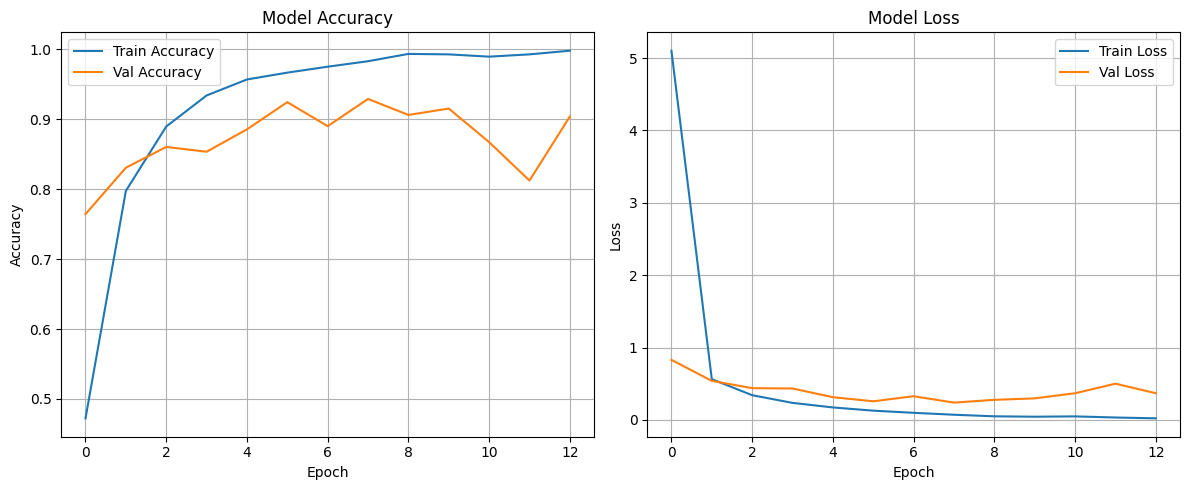

In [57]:
# load history

plot_history(history.history)



### Confusion Matrix

In [122]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [164]:
# predict with simple model
pred = predict(best_model_1, X_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step


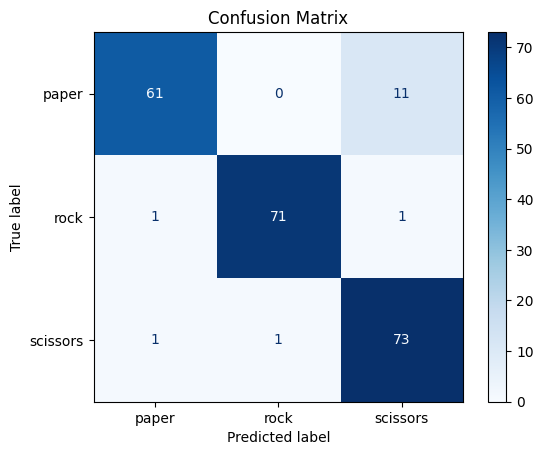

              precision    recall  f1-score   support

       paper  0.9682540 0.8472222 0.9037037        72
        rock  0.9861111 0.9726027 0.9793103        73
    scissors  0.8588235 0.9733333 0.9125000        75

    accuracy                      0.9318182       220
   macro avg  0.9377295 0.9310528 0.9318380       220
weighted avg  0.9368735 0.9318182 0.9317901       220



In [169]:
plot_confusion_matrix(y_test, pred, classes)
print(classification_report(y_test,pred,target_names = classes, digits=7))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
              precision    recall  f1-score   support

       paper  0.9655172 0.7777778 0.8615385        72
        rock  0.9729730 0.9863014 0.9795918        73
    scissors  0.8181818 0.9600000 0.8834356        75

    accuracy                      0.9090909       220
   macro avg  0.9188907 0.9080264 0.9081886       220
weighted avg  0.9177632 0.9090909 0.9081756       220



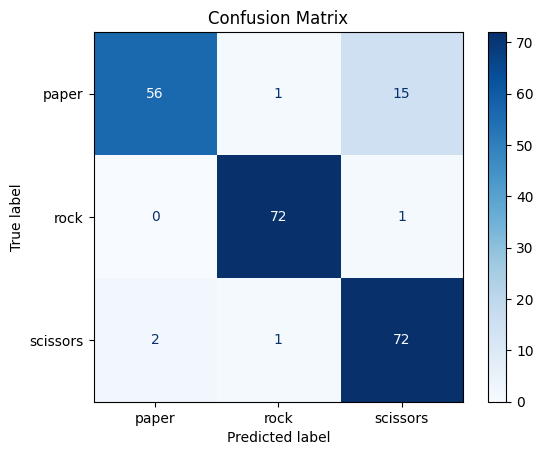

In [182]:
# predict with improved model
pred_improvement = predict(model_1_improvement, X_test)
print(classification_report(y_test,pred_improvement,target_names = classes, digits=7))
plot_confusion_matrix(y_test, pred_improvement, classes)

### Making a more complex model

In [196]:
model_2 = Sequential()
model_2.add(Input(shape=(150, 150, 3)))

model_2.add(Conv2D(32, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(2, 2))
model_2.add(Dropout(0.1))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(2, 2))
model_2.add(Dropout(0.1))

model_2.add(Flatten())
model_2.add(Dense(units=128, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(units=512, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(units=3, activation='softmax'))



model_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_2.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,703,939 (40.83 MB)

 Trainable params: 10,703,939 (40.83 MB)

 Non-trainable params: 0 (0.00 B)

In [190]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                               factor=0.1, 
                               patience=2, 
                               min_lr=0.000001)
history_2 = model_2.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    epochs=10,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 366ms/step - accuracy: 0.3467 - loss: 1.4362 - val_accuracy: 0.7094 - val_loss: 0.9259 - learning_rate: 0.0010
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 333ms/step - accuracy: 0.7028 - loss: 0.7492 - val_accuracy: 0.7300 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 360ms/step - accuracy: 0.8221 - loss: 0.4336 - val_accuracy: 0.8833 - val_loss: 0.3244 - learning_rate: 0.0010
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 331ms/step - accuracy: 0.9170 - loss: 0.2378 - val_accuracy: 0.8947 - val_loss: 0.2971 - learning_rate: 0.0010
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 355ms/step - accuracy: 0.9595 - loss: 0.1407 - val_accuracy: 0.8993 - val_loss: 0.2691 - learning_rate: 0.0010
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 336ms/step - accuracy: 0.9363 - loss: 0.1610 - val_accuracy: 0.9268 - val_loss: 0.2127 - learning_rate: 0.0010
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 333ms/step - accuracy: 0.9632 - loss: 0.

In [191]:
# save
# 1 128
# 2 256
model_2.save("rock_paper_scissors_intermmediate_cnn.keras")

# save history
with open("history_intermediate2.json", "w") as f:
    json.dump(history_2.history, f)

In [31]:
# load model
import keras
model_2_org = keras.models.load_model("rock_paper_scissors_intermmediate_cnn.keras")

# load history
with open("history_intermediate.json", "r") as f:
    history_2_org = json.load(f)

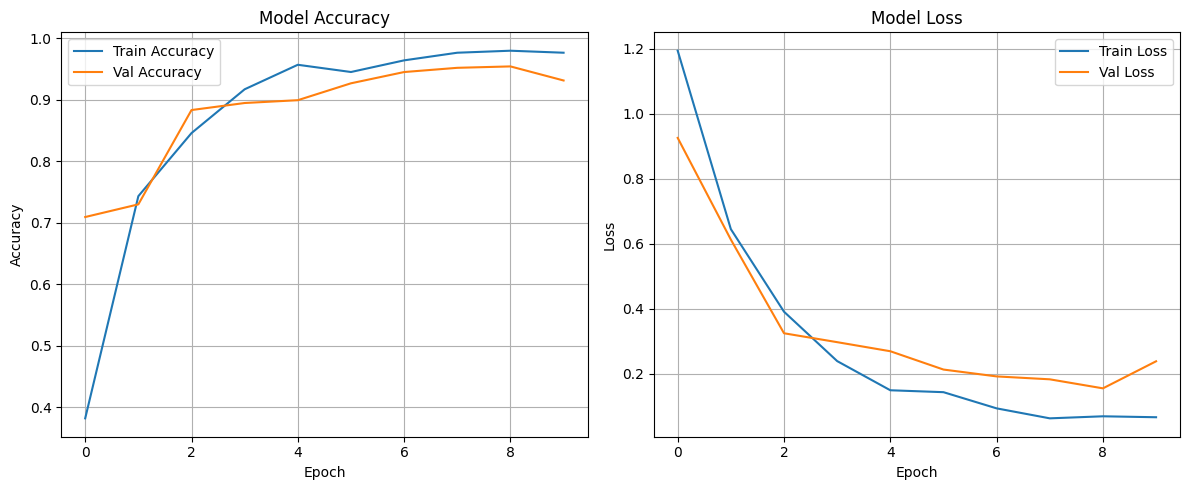

In [192]:
# plot training history
plot_history(history_2.history)
# plot_history(history_2_org)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


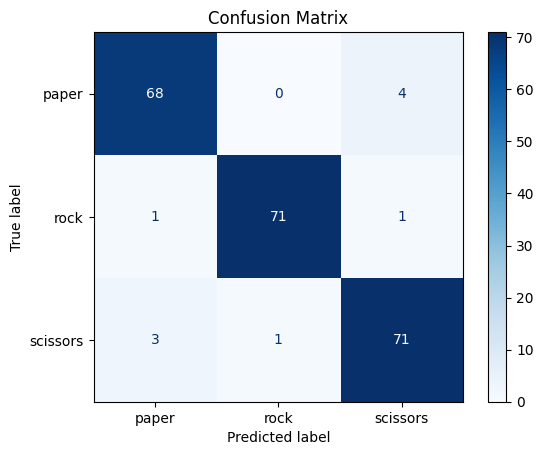

              precision    recall  f1-score   support

       paper  0.9444444 0.9444444 0.9444444        72
        rock  0.9861111 0.9726027 0.9793103        73
    scissors  0.9342105 0.9466667 0.9403974        75

    accuracy                      0.9545455       220
   macro avg  0.9549220 0.9545713 0.9547174       220
weighted avg  0.9547814 0.9545455 0.9546339       220



In [195]:
y_pred = model_2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # if using one-hot



plot_confusion_matrix(y_test, y_pred_classes, classes)
print(classification_report(y_test, y_pred_classes, digits=7, target_names=classes))